# 🔍 YOLO v11n Inference - Industrial Product Detection

Notebook này dùng để inference với model YOLOv11n đã train cho việc detect sản phẩm công nghiệp.

## Nội dung:
1. Load model (PyTorch hoặc ONNX)
2. Inference trên ảnh đơn
3. Inference trên nhiều ảnh (batch)
4. Inference trên video
5. Webcam realtime (tùy chọn)

---

## 1. Import Libraries & Configuration

In [1]:
from ultralytics import YOLO
import cv2
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Video, HTML
import time

# ============================================
# CONFIGURATION
# ============================================

# Đường dẫn model - chọn 1 trong 2:
MODEL_PT = "yolo_industrial_product/yolov11n/weights/best.pt"   # PyTorch model
MODEL_ONNX = "yolo_industrial_product/yolov11n/weights/best.onnx"  # ONNX model

# Chọn model để sử dụng (True = ONNX, False = PyTorch)
USE_ONNX = False

# Ngưỡng confidence và IOU
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.45

# Kích thước ảnh inference
IMG_SIZE = 640

# Folder output
OUTPUT_DIR = "inference_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ Configuration loaded")
print(f"   Model: {'ONNX' if USE_ONNX else 'PyTorch'}")
print(f"   Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"   IOU threshold: {IOU_THRESHOLD}")
print(f"   Image size: {IMG_SIZE}")

✅ Configuration loaded
   Model: PyTorch
   Confidence threshold: 0.5
   IOU threshold: 0.45
   Image size: 640


In [2]:
# Load model
model_path = MODEL_ONNX if USE_ONNX else MODEL_PT

if os.path.exists(model_path):
    model = YOLO(model_path)
    print(f"✅ Model loaded: {model_path}")
    
    # Hiển thị thông tin model
    if not USE_ONNX:
        model.info()
else:
    print(f"❌ Model không tồn tại: {model_path}")
    print("   Hãy đảm bảo đã copy folder yolo_industrial_product từ training results")

✅ Model loaded: yolo_industrial_product/yolov11n/weights/best.pt
YOLO11n summary: 181 layers, 2,590,035 parameters, 0 gradients, 6.4 GFLOPs


## 2. Helper Functions

In [3]:
def inference_image(image_path, save=True, show=True):
    """
    Inference trên một ảnh đơn
    
    Args:
        image_path: Đường dẫn ảnh
        save: Lưu kết quả
        show: Hiển thị kết quả
    
    Returns:
        results: Kết quả detection
    """
    # Run inference
    results = model.predict(
        source=image_path,
        conf=CONFIDENCE_THRESHOLD,
        iou=IOU_THRESHOLD,
        imgsz=IMG_SIZE,
        verbose=False
    )
    
    # Lấy ảnh với bounding boxes
    result = results[0]
    img_with_boxes = result.plot()
    
    # Hiển thị
    if show:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Detection Results: {Path(image_path).name}')
        plt.show()
    
    # Lưu kết quả
    if save:
        output_path = os.path.join(OUTPUT_DIR, f"detected_{Path(image_path).name}")
        cv2.imwrite(output_path, img_with_boxes)
        print(f"💾 Saved: {output_path}")
    
    # In thông tin detections
    boxes = result.boxes
    print(f"\n📊 Detection Results for {Path(image_path).name}:")
    print(f"   Found {len(boxes)} objects")
    
    for i, box in enumerate(boxes):
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        class_name = result.names[cls]
        xyxy = box.xyxy[0].cpu().numpy()
        print(f"   [{i+1}] {class_name}: {conf:.2%} | Box: [{xyxy[0]:.0f}, {xyxy[1]:.0f}, {xyxy[2]:.0f}, {xyxy[3]:.0f}]")
    
    return results


def inference_batch(image_folder, save=True):
    """
    Inference trên nhiều ảnh trong folder
    
    Args:
        image_folder: Đường dẫn folder chứa ảnh
        save: Lưu kết quả
    
    Returns:
        all_results: List kết quả detection
    """
    # Lấy danh sách ảnh
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.webp']
    images = [f for f in os.listdir(image_folder) 
              if Path(f).suffix.lower() in image_extensions]
    
    print(f"📁 Found {len(images)} images in {image_folder}")
    
    all_results = []
    total_objects = 0
    
    for img_name in images:
        img_path = os.path.join(image_folder, img_name)
        results = model.predict(
            source=img_path,
            conf=CONFIDENCE_THRESHOLD,
            iou=IOU_THRESHOLD,
            imgsz=IMG_SIZE,
            verbose=False
        )
        
        result = results[0]
        num_objects = len(result.boxes)
        total_objects += num_objects
        
        print(f"   ✓ {img_name}: {num_objects} objects detected")
        
        # Lưu kết quả
        if save:
            img_with_boxes = result.plot()
            output_path = os.path.join(OUTPUT_DIR, f"detected_{img_name}")
            cv2.imwrite(output_path, img_with_boxes)
        
        all_results.append(results)
    
    print(f"\n📊 Total: {total_objects} objects detected in {len(images)} images")
    if save:
        print(f"💾 Results saved to: {OUTPUT_DIR}")
    
    return all_results


def inference_video(video_path, save=True, show_progress=True):
    """
    Inference trên video
    
    Args:
        video_path: Đường dẫn video
        save: Lưu video kết quả
        show_progress: Hiển thị progress
    
    Returns:
        output_path: Đường dẫn video output
    """
    # Kiểm tra video tồn tại
    if not os.path.exists(video_path):
        print(f"❌ Video không tồn tại: {video_path}")
        return None
    
    # Mở video
    cap = cv2.VideoCapture(video_path)
    
    # Lấy thông tin video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video info:")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Total frames: {total_frames}")
    print(f"   Duration: {total_frames/fps:.2f}s")
    
    # Tạo video writer
    output_path = os.path.join(OUTPUT_DIR, f"detected_{Path(video_path).name}")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Process từng frame
    frame_count = 0
    total_detections = 0
    start_time = time.time()
    
    print(f"\n🔄 Processing video...")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Inference
        results = model.predict(
            source=frame,
            conf=CONFIDENCE_THRESHOLD,
            iou=IOU_THRESHOLD,
            imgsz=IMG_SIZE,
            verbose=False
        )
        
        # Vẽ kết quả
        result = results[0]
        frame_with_boxes = result.plot()
        
        # Ghi video
        if save:
            out.write(frame_with_boxes)
        
        frame_count += 1
        total_detections += len(result.boxes)
        
        # Progress
        if show_progress and frame_count % 30 == 0:
            progress = frame_count / total_frames * 100
            elapsed = time.time() - start_time
            eta = (elapsed / frame_count) * (total_frames - frame_count)
            print(f"   Progress: {progress:.1f}% | Frame: {frame_count}/{total_frames} | ETA: {eta:.1f}s")
    
    # Cleanup
    cap.release()
    out.release()
    
    elapsed_time = time.time() - start_time
    avg_fps = frame_count / elapsed_time
    
    print(f"\n✅ Video processing completed!")
    print(f"   Processed {frame_count} frames in {elapsed_time:.2f}s")
    print(f"   Average FPS: {avg_fps:.2f}")
    print(f"   Total detections: {total_detections}")
    print(f"   Average detections/frame: {total_detections/frame_count:.2f}")
    
    if save:
        print(f"💾 Output saved: {output_path}")
    
    return output_path

print("✅ Helper functions loaded")

✅ Helper functions loaded


## 3. Inference trên Ảnh đơn

Chỉ định đường dẫn ảnh và chạy inference

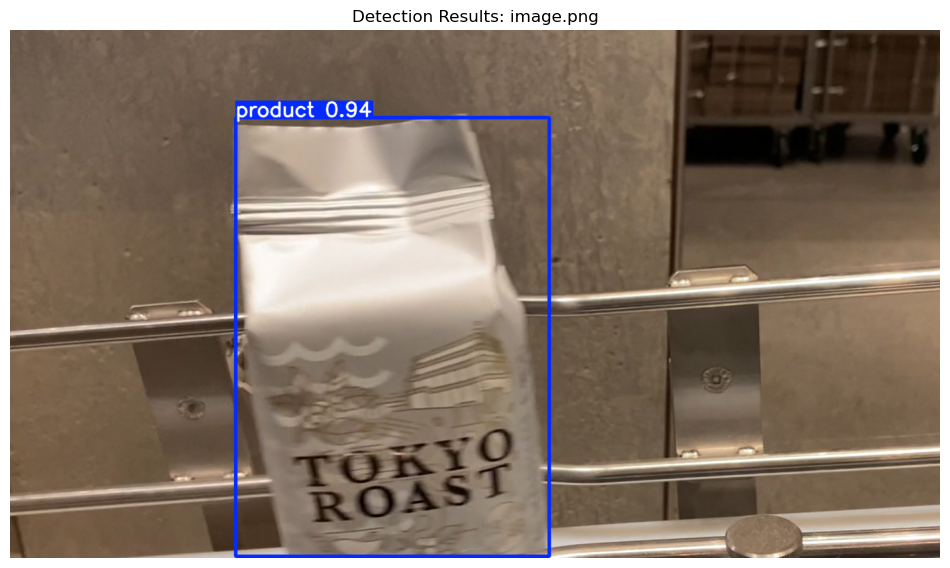

💾 Saved: inference_results\detected_image.png

📊 Detection Results for image.png:
   Found 1 objects
   [1] product: 93.60% | Box: [340, 134, 813, 794]


In [4]:
# ============================================
# INFERENCE TRÊN ẢNH ĐƠN
# ============================================

# Chỉ định đường dẫn ảnh
IMAGE_PATH = "video/image.png"  # <-- Thay đổi đường dẫn ảnh tại đây

# Hoặc sử dụng ảnh từ validation set
# IMAGE_PATH = "industrial_product_dataset/images/val/00000.jpg"

if os.path.exists(IMAGE_PATH):
    results = inference_image(IMAGE_PATH, save=True, show=True)
else:
    print(f"⚠️ Ảnh không tồn tại: {IMAGE_PATH}")
    print("   Hãy thay đổi IMAGE_PATH thành đường dẫn ảnh hợp lệ")

## 4. Inference trên Batch Ảnh

Inference trên tất cả ảnh trong một folder

In [ ]:
# ============================================
# INFERENCE TRÊN BATCH ẢNH
# ============================================

# Chỉ định folder chứa ảnh
IMAGE_FOLDER = "path/to/your/image_folder"  # <-- Thay đổi đường dẫn folder tại đây

# Hoặc sử dụng folder validation
# IMAGE_FOLDER = "industrial_product_dataset/images/val"

if os.path.isdir(IMAGE_FOLDER):
    batch_results = inference_batch(IMAGE_FOLDER, save=True)
else:
    print(f"⚠️ Folder không tồn tại: {IMAGE_FOLDER}")
    print("   Hãy thay đổi IMAGE_FOLDER thành đường dẫn folder hợp lệ")

⚠️ Folder không tồn tại: video/valHD.mp4
   Hãy thay đổi IMAGE_FOLDER thành đường dẫn folder hợp lệ


## 5. Inference trên Video

Chỉ định đường dẫn video và chạy inference

In [6]:
# ============================================
# INFERENCE TRÊN VIDEO
# ============================================

# Chỉ định đường dẫn video
VIDEO_PATH = "video/valHD.mp4"  # <-- Thay đổi đường dẫn video tại đây


if os.path.exists(VIDEO_PATH):
    output_video = inference_video(VIDEO_PATH, save=True, show_progress=True)
else:
    print(f"⚠️ Video không tồn tại: {VIDEO_PATH}")
    print("   Hãy thay đổi VIDEO_PATH thành đường dẫn video hợp lệ")

📹 Video info:
   Resolution: 1280x720
   FPS: 23
   Total frames: 1527
   Duration: 66.39s

🔄 Processing video...
   Progress: 2.0% | Frame: 30/1527 | ETA: 78.7s
   Progress: 2.0% | Frame: 30/1527 | ETA: 78.7s
   Progress: 3.9% | Frame: 60/1527 | ETA: 73.6s
   Progress: 3.9% | Frame: 60/1527 | ETA: 73.6s
   Progress: 5.9% | Frame: 90/1527 | ETA: 75.5s
   Progress: 5.9% | Frame: 90/1527 | ETA: 75.5s
   Progress: 7.9% | Frame: 120/1527 | ETA: 77.4s
   Progress: 7.9% | Frame: 120/1527 | ETA: 77.4s
   Progress: 9.8% | Frame: 150/1527 | ETA: 77.5s
   Progress: 9.8% | Frame: 150/1527 | ETA: 77.5s
   Progress: 11.8% | Frame: 180/1527 | ETA: 76.8s
   Progress: 11.8% | Frame: 180/1527 | ETA: 76.8s
   Progress: 13.8% | Frame: 210/1527 | ETA: 76.2s
   Progress: 13.8% | Frame: 210/1527 | ETA: 76.2s
   Progress: 15.7% | Frame: 240/1527 | ETA: 74.8s
   Progress: 15.7% | Frame: 240/1527 | ETA: 74.8s
   Progress: 17.7% | Frame: 270/1527 | ETA: 73.2s
   Progress: 17.7% | Frame: 270/1527 | ETA: 73.2s
  

## 6. Webcam Realtime (Tùy chọn)

Inference realtime từ webcam - nhấn 'q' để thoát

In [ ]:
# ============================================
# WEBCAM REALTIME INFERENCE
# ============================================
# Chạy cell này để inference từ webcam
# Nhấn 'q' để thoát

def inference_webcam(camera_id=0, save_video=False):
    """
    Inference realtime từ webcam
    
    Args:
        camera_id: ID của camera (0 = webcam mặc định)
        save_video: Lưu video output
    """
    cap = cv2.VideoCapture(camera_id)
    
    if not cap.isOpened():
        print("❌ Không thể mở webcam")
        return
    
    # Lấy thông tin
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
    
    print(f"📹 Webcam info: {width}x{height} @ {fps}fps")
    print("   Nhấn 'q' để thoát")
    
    # Video writer nếu cần lưu
    out = None
    if save_video:
        output_path = os.path.join(OUTPUT_DIR, "webcam_detection.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # FPS counter
    prev_time = time.time()
    fps_list = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Inference
        results = model.predict(
            source=frame,
            conf=CONFIDENCE_THRESHOLD,
            iou=IOU_THRESHOLD,
            imgsz=IMG_SIZE,
            verbose=False
        )
        
        # Vẽ kết quả
        result = results[0]
        frame_with_boxes = result.plot()
        
        # Tính FPS
        current_time = time.time()
        fps_current = 1 / (current_time - prev_time)
        prev_time = current_time
        fps_list.append(fps_current)
        if len(fps_list) > 30:
            fps_list.pop(0)
        avg_fps = sum(fps_list) / len(fps_list)
        
        # Hiển thị FPS và số objects
        num_objects = len(result.boxes)
        cv2.putText(frame_with_boxes, f"FPS: {avg_fps:.1f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame_with_boxes, f"Objects: {num_objects}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Hiển thị
        cv2.imshow("YOLO Detection - Press 'q' to quit", frame_with_boxes)
        
        # Lưu video
        if save_video and out:
            out.write(frame_with_boxes)
        
        # Thoát khi nhấn 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Cleanup
    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()
    
    print("✅ Webcam inference stopped")
    if save_video:
        print(f"💾 Video saved: {output_path}")

# Uncomment dòng dưới để chạy webcam
# inference_webcam(camera_id=0, save_video=True)

## 7. Quick Inference với YOLO CLI

Sử dụng YOLO CLI để inference nhanh (không cần code)

In [ ]:
# ============================================
# QUICK INFERENCE VỚI YOLO CLI
# ============================================

# Inference trên ảnh
# !yolo predict model=yolo_industrial_product/yolov11n/weights/best.pt source="path/to/image.jpg" conf=0.5

# Inference trên video
# !yolo predict model=yolo_industrial_product/yolov11n/weights/best.pt source="path/to/video.mp4" conf=0.5

# Inference trên folder
# !yolo predict model=yolo_industrial_product/yolov11n/weights/best.pt source="path/to/folder" conf=0.5

# Inference trên webcam
# !yolo predict model=yolo_industrial_product/yolov11n/weights/best.pt source=0 conf=0.5 show=True

print("📌 Uncomment và chỉnh sửa các lệnh trên để sử dụng YOLO CLI")

## 📝 Tóm tắt

### Cách sử dụng:
1. **Load model**: Cell 2 - tự động load model từ `best.pt` hoặc `best.onnx`
2. **Ảnh đơn**: Cell 5 - thay đổi `IMAGE_PATH` và chạy
3. **Batch ảnh**: Cell 7 - thay đổi `IMAGE_FOLDER` và chạy
4. **Video**: Cell 9 - thay đổi `VIDEO_PATH` và chạy
5. **Webcam**: Cell 11 - uncomment dòng cuối và chạy

### Output:
- Tất cả kết quả được lưu trong folder `inference_results/`
- Ảnh: `detected_<tên_file>.jpg`
- Video: `detected_<tên_file>.mp4`

### Tips:
- Điều chỉnh `CONFIDENCE_THRESHOLD` nếu có quá nhiều false positives
- Sử dụng ONNX model (`USE_ONNX = True`) để inference nhanh hơn trên CPU
- Với video dài, kiểm tra GPU memory để tránh OOM